In [ ]:
!pip install -q optbinning ppscore

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from optbinning import BinningProcess
import ppscore as pps
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
import optbinning
print(pd.__version__)
print(np.__version__)
print(optbinning.__version__)
print(pps.__version__)
!python --version

1.5.3
1.26.4
0.20.1
1.3.0
Python 3.10.12


In [4]:
# Load the dataset
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

train = train.drop(columns=['id'])

print(train.shape)
train.head()

(58645, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# Exploratory Data Analysis (EDA)
## Duplicate Check 

In [5]:
# Check duplicates
sum(train.duplicated())
# There is no data duplicate

0

In [6]:
# Check duplicated features
sum(train[train.columns[:-1]].duplicated())
# There is no feature duplicate

0

## Data Distribution
### Numerical Features

In [7]:
train.info()
# There is no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [8]:
train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


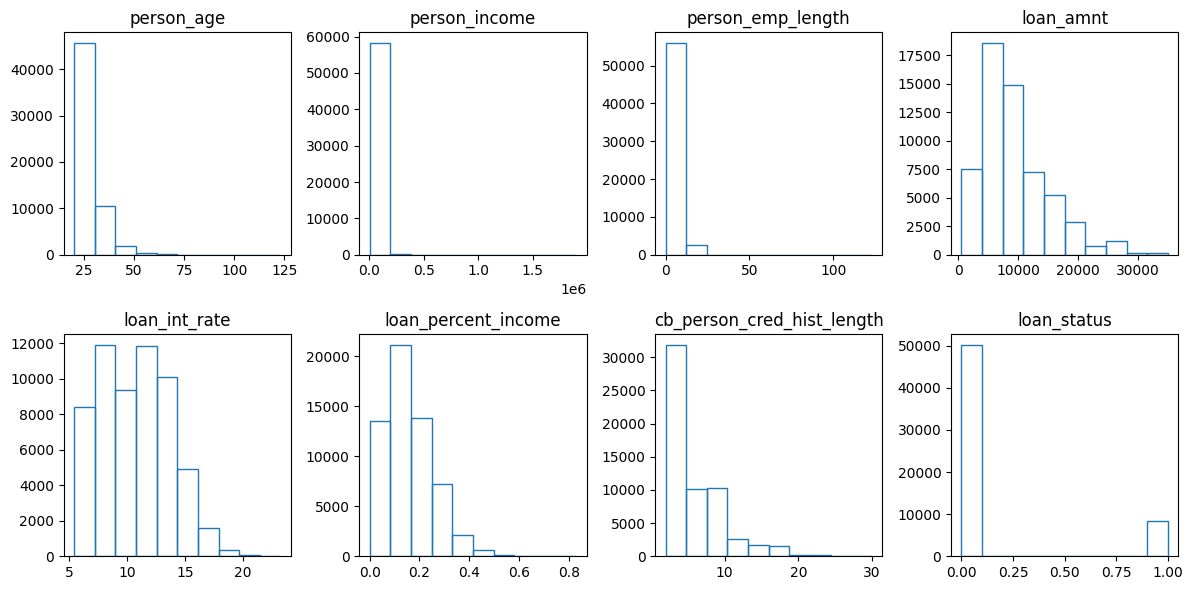

In [9]:
# Visualize numerical features
fig, ax = plt.subplots(2, 4, figsize=(12,6))

row = 0
column = 0
for col in [
    'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
    'loan_percent_income', 'cb_person_cred_hist_length', 'loan_status'
]:
    ax[row, column].hist(train[col], edgecolor='tab:blue', fill=False)
    ax[row, column].set_title(col)
    
    column += 1
    if column == 4:
        column = 0
        row+= 1

plt.tight_layout()
plt.show()
# Outliers may be found 'person_age', 'person_income', 'person_emp_length'

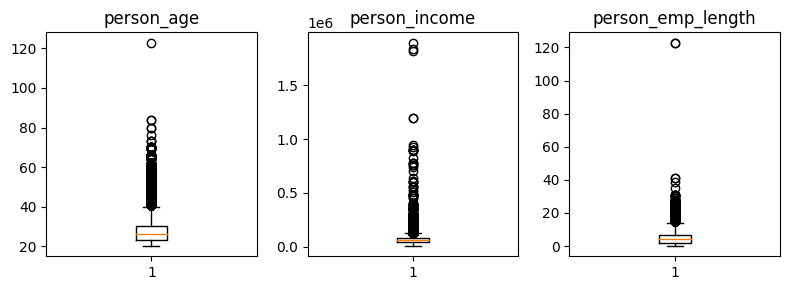

In [10]:
# Visualize numerical features
fig, ax = plt.subplots(1, 3, figsize=(8,3))

column = 0
for col in ['person_age', 'person_income', 'person_emp_length']:
    ax[column].boxplot(train[col])
    ax[column].set_title(col)
    
    column += 1

plt.tight_layout()
plt.show()
# Remove extreme outliers:
# person_age > 100
# person_emp_length > 60

In [11]:
train = train[((train['person_age'] < 100) & (train['person_emp_length'] < 60))]
train.shape

(58642, 12)

In [12]:
train['loan_status'].value_counts()/train.shape[0]*100
# Imbalanced dataset

0    85.762764
1    14.237236
Name: loan_status, dtype: float64

### Categorical Features

In [13]:
# Explore categorical features
# Count the unique values
for categorical in ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']:
    num_unique = len(train[categorical].unique())
    print(f'{categorical}: {num_unique}')

person_home_ownership: 4
loan_intent: 6
loan_grade: 7
cb_person_default_on_file: 2


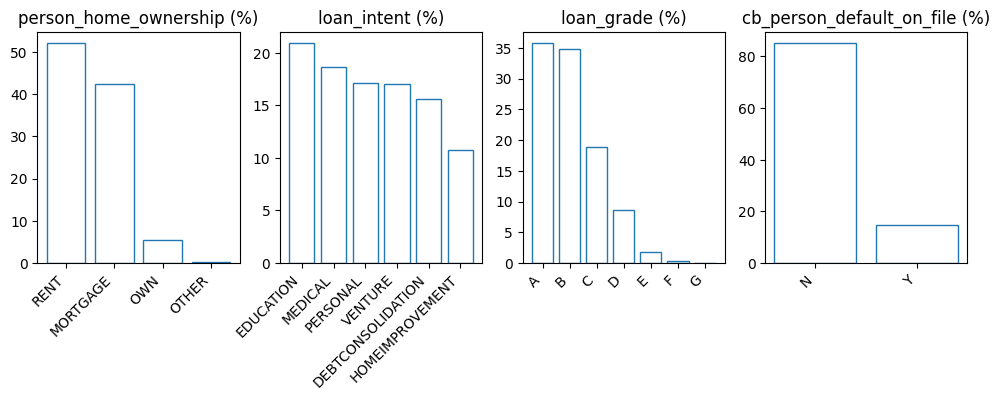

In [14]:
# Plot the count bar
fig, ax = plt.subplots(1, 4, figsize=(12,3))

column = 0
for categorical in ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']:
    # Only select top 8 values, if there are more than 8 unique values
    bar_plot = pd.DataFrame(train[categorical].value_counts().sort_values(ascending=False)).reset_index().head(8)
    bar_plot.columns = ['category', 'count']
    bar_plot['percentage'] = bar_plot['count'] / train.shape[0] * 100

    ax[column].bar(x=bar_plot['category'], height=bar_plot['percentage'], fill=False, edgecolor='tab:blue')
    ax[column].set_title(categorical + ' (%)')
    ax[column].set_xticklabels(bar_plot['category'], rotation=45, ha='right')

    column += 1

plt.show()
# loan_grade should not be a predictive feature. A new user will not have a loan grade.

## Train-test split

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns=['loan_status'], axis=0),
    train['loan_status'],
    test_size=0.2, random_state=123,
    stratify=train['loan_status']
)
print(X_train.shape)
print(X_val.shape)

(46913, 11)
(11729, 11)


In [35]:
X_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
28905,22,53760,RENT,3.0,PERSONAL,C,4000,13.43,0.07,N,2
34862,22,26886,RENT,6.0,PERSONAL,C,7500,13.49,0.28,Y,2
32740,26,57000,MORTGAGE,10.0,VENTURE,A,3500,7.68,0.06,N,4
45780,23,48000,RENT,8.0,EDUCATION,B,5000,12.42,0.10,N,3
21826,34,62500,MORTGAGE,2.0,MEDICAL,B,16000,10.99,0.26,N,7


In [17]:
# Save train test split id
pd.DataFrame(y_train).to_csv('train_id.csv')
pd.DataFrame(y_val).to_csv('val_id.csv')

# Feature Engineering
## Optimal Binning

In [18]:
X_train = train.drop(columns=['loan_status'])
X_test = test
y_train = train['loan_status']

In [21]:
# Optimal binning
var_num = [
    'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate',
    'loan_percent_income', 'cb_person_cred_hist_length'
]
var_cate = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Numerical
binning_fit_params = {v:{'monotonic_trend':'auto_asc_desc'} for v in var_num}

# Binning process
bin_proc_num = BinningProcess(
    var_num,
    max_n_bins=8,
    binning_fit_params=binning_fit_params
)

# Categorical
bin_proc_cate = BinningProcess(
    var_cate,
    max_n_bins=8,
)

# Apply opt binning to train dataset
train_bin = X_train.copy()
train_bin[var_num] = bin_proc_num.fit_transform(train_bin[var_num].values, y_train)
train_bin[var_cate] = bin_proc_cate.fit_transform(train_bin[var_cate].values, y_train)

print(train_bin.shape)
train_bin.head(3)

(58642, 11)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,0.057445,-0.481576,-0.544008,-0.444348,0.318378,0.376050,0.390676,0.124293,0.316649,0.243794,-0.133827
1,-0.156593,0.023993,2.480619,0.286643,-0.266971,0.058522,0.390676,0.124293,0.930195,0.243794,0.009359
2,0.057445,-1.186918,2.480619,0.425602,0.080694,1.166107,0.390676,0.764084,0.316649,0.243794,0.009359


In [22]:
# Summary
bin_proc_num.summary().sort_values('iv', ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
5,loan_percent_income,numerical,OPTIMAL,True,8,1.245736,0.129042,0.486447,0.009486
4,loan_int_rate,numerical,OPTIMAL,True,8,1.117075,0.124182,0.523274,0.079507
1,person_income,numerical,OPTIMAL,True,8,0.608331,0.071244,0.412737,0.223073
3,loan_amnt,numerical,OPTIMAL,True,5,0.177468,0.021802,0.221472,0.546453
2,person_emp_length,numerical,OPTIMAL,True,7,0.128329,0.015914,0.197731,0.061269
0,person_age,numerical,OPTIMAL,True,3,0.005389,0.000673,0.035378,0.01686
6,cb_person_cred_hist_length,numerical,OPTIMAL,True,2,0.001252,0.000156,0.008747,0.000811


In [23]:
bin_proc_cate.summary().sort_values('iv', ascending=False)

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
2,loan_grade,categorical,OPTIMAL,True,4,1.238536,0.13481,0.517434,0.032557
0,person_home_ownership,categorical,OPTIMAL,True,3,0.601825,0.070238,0.351477,0.536651
3,cb_person_default_on_file,categorical,OPTIMAL,True,2,0.225575,0.027388,0.190105,0.269186
1,loan_intent,categorical,OPTIMAL,True,6,0.095048,0.011811,0.168797,0.18774


In [24]:
bin_proc_num.get_binned_variable('loan_percent_income').binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.05)",5518,0.094096,5188,330,0.059804,0.959287,0.061039,0.007350
1,"[0.05, 0.07)",5174,0.088230,4856,318,0.061461,0.930195,0.054385,0.006563
2,"[0.07, 0.13)",17150,0.292453,15885,1265,0.073761,0.734579,0.120716,0.014759
3,"[0.13, 0.16)",6861,0.116998,6223,638,0.092989,0.481945,0.022805,0.002823
4,"[0.16, 0.21)",10000,0.170526,8921,1079,0.107900,0.316649,0.015245,0.001898
5,"[0.21, 0.25)",5242,0.089390,4569,673,0.128386,0.11958,0.001224,0.000153
6,"[0.25, 0.31)",3968,0.067665,3216,752,0.189516,-0.342567,0.008950,0.001113
7,"[0.31, inf)",4729,0.080642,1435,3294,0.696553,-2.626662,0.961373,0.094382
8,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
9,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000


In [26]:
bin_proc_cate.get_binned_variable('person_home_ownership').binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[OWN],3138,0.053511,3095,43,0.013703,2.480619,0.139880,0.014045
1,[MORTGAGE],24821,0.423263,23339,1482,0.059708,0.961009,0.275381,0.033156
2,"[OTHER, RENT]",30683,0.523226,23859,6824,0.222403,-0.544008,0.186564,0.023037
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,58642,1.000000,50293,8349,0.142372,,0.601825,0.070238


In [27]:
# Compile opt binning tables
# Sort the variables based on IV
var_num_sort = list(bin_proc_num.summary().sort_values('iv', ascending=False)['name'].values)
var_obj_sort = list(bin_proc_cate.summary().sort_values('iv', ascending=False)['name'].values)

# Numerical
bin_table_num = pd.DataFrame(
    {'Feature':[], 'Bin':[], 'Count':[], 'Count (%)':[], 'Sum':[], 'Std':[], 'Mean':[],
     'Min':[], 'Max':[], 'Zeros count':[], 'WoE':[], 'IV':[]}
)
for c in var_num_sort:
    df_bin = bin_proc_num.get_binned_variable(c).binning_table.build()
    df_bin = df_bin[df_bin['Count']!=0]
    df_bin.insert(0, 'Feature', c)
    bin_table_num = pd.concat([bin_table_num, df_bin], axis=0, ignore_index=True)

# Object
bin_table_cate = pd.DataFrame(
    {'Feature':[], 'Bin':[], 'Count':[], 'Count (%)':[], 'Sum':[], 'Std':[], 'Mean':[],
     'Min':[], 'Max':[], 'Zeros count':[], 'WoE':[], 'IV':[]}
)
for c in var_obj_sort:
    df_bin = bin_proc_cate.get_binned_variable(c).binning_table.build()
    df_bin = df_bin[df_bin['Count']!=0]
    df_bin.insert(0, 'Feature', c)
    bin_table_cate = pd.concat([bin_table_cate, df_bin], axis=0, ignore_index=True)

In [28]:
# Save opt binning
bin_table_num.to_csv('bin_table_num.csv', index=False)
bin_table_cate.to_csv('bin_table_cate.csv', index=False)

In [29]:
# Save opt binning pickle
pickle.dump(bin_proc_num, open('bin_proc_num.pkl', 'wb'))
pickle.dump(bin_proc_cate, open('bin_proc_cate.pkl', 'wb'))

## Feature Transformation

In [36]:
# Apply optimal binning
X_train['loan_intent'] = train_bin['loan_intent']

# One-hot encoding for some feaures
X_train['home_own'] = np.where(X_train['person_home_ownership'] == 'OWN', 1, 0)
X_train['home_mortgage'] = np.where(X_train['person_home_ownership'] == 'MORTGAGE', 1, 0)
X_train['cb_person_default_on_file'] = np.where(X_train['cb_person_default_on_file'] == 'Y', 1, 0)

X_train = X_train.drop(columns=['loan_grade', 'person_home_ownership'])
X_train.head()

,person_age,person_income,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,home_own,home_mortgage
28905,22,53760,3.0,0.080694,4000,13.43,0.07,0,2,0,0
34862,22,26886,6.0,0.080694,7500,13.49,0.28,1,2,0,0
32740,26,57000,10.0,0.484107,3500,7.68,0.06,0,4,0,1
45780,23,48000,8.0,0.318378,5000,12.42,0.10,0,3,0,0
21826,34,62500,2.0,-0.266971,16000,10.99,0.26,0,7,0,1


In [38]:
# Apply to the validation set
val_bin = X_val.copy()
val_bin[var_cate] = bin_proc_cate.transform(test_bin[var_cate].values)

# Apply optimal binning
X_val['loan_intent'] = val_bin['loan_intent']

# One-hot encoding for some feaures
X_val['home_own'] = np.where(X_val['person_home_ownership'] == 'OWN', 1, 0)
X_val['home_mortgage'] = np.where(X_val['person_home_ownership'] == 'MORTGAGE', 1, 0)
X_val['cb_person_default_on_file'] = np.where(X_val['cb_person_default_on_file'] == 'Y', 1, 0)

X_val = X_val.drop(columns=['loan_grade', 'person_home_ownership'])
X_val.head()

,person_age,person_income,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,home_own,home_mortgage
56540,24,51000,2.0,0.0,8000,13.11,0.16,0,4,0,1
47660,48,50000,7.0,0.0,11000,10.99,0.22,0,11,0,1
56169,22,365000,6.0,0.0,35000,12.18,0.10,0,3,0,1
29403,32,90000,13.0,0.0,15000,6.54,0.17,0,5,0,1
1664,26,39000,3.0,0.0,3000,10.99,0.08,0,3,0,0


In [42]:
# Apply to the testing set
test_bin = test.copy()
test_bin[var_cate] = bin_proc_cate.transform(test_bin[var_cate].values)

# Apply optimal binning
test['loan_intent'] = test_bin['loan_intent']

# One-hot encoding for some feaures
test['home_own'] = np.where(test['person_home_ownership'] == 'OWN', 1, 0)
test['home_mortgage'] = np.where(test['person_home_ownership'] == 'MORTGAGE', 1, 0)
test['cb_person_default_on_file'] = np.where(test['cb_person_default_on_file'] == 'Y', 1, 0)

X_test = test.copy()
X_test = X_test.drop(columns=['loan_grade', 'person_home_ownership'])
X_test.head()

,person_age,person_income,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,home_own,home_mortgage
0,23,69000,3.0,0.0,25000,15.76,0.36,0,2,0,0
1,26,96000,6.0,0.0,10000,12.68,0.10,1,4,0,1
2,26,30000,5.0,0.0,4000,17.19,0.13,1,2,0,0
3,33,50000,4.0,0.0,7000,8.90,0.14,0,7,0,0
4,26,102000,8.0,0.0,15000,16.32,0.15,1,4,0,1


In [44]:
# Save
X_train.to_csv('X_train.csv')
X_val.to_csv('X_val.csv')
X_test.to_csv('X_test.csv')

## Predictive Power Score (PPS)

In [45]:
# PPS is the substitute to the correlation test that is usually userd to find features with strong relationship
# Apply predictive power
train_pps = pps.matrix(pd.concat([X_train, y_train], axis=1))
train_pps.head()

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,person_age,person_age,1.0,predict_itself,True,None,0.000000,1.000000,None
1,person_age,person_income,0.0,regression,True,mean absolute error,22625.706400,23283.308945,DecisionTreeRegressor()
2,person_age,person_emp_length,0.0,regression,True,mean absolute error,2.965200,3.122850,DecisionTreeRegressor()
3,person_age,loan_intent,0.0,regression,True,mean absolute error,0.281256,0.281984,DecisionTreeRegressor()
4,person_age,loan_amnt,0.0,regression,True,mean absolute error,4190.255000,4297.058857,DecisionTreeRegressor()


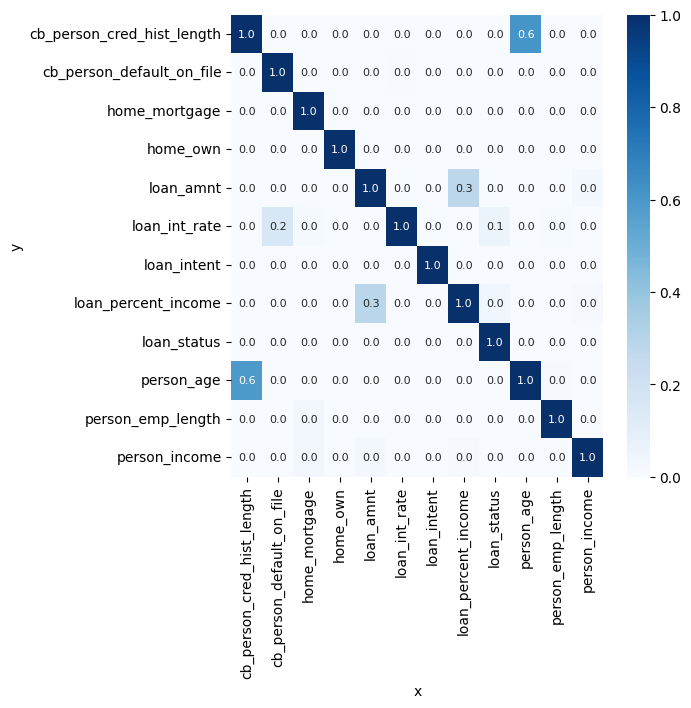

In [46]:
# Plot pps
plt.figure(figsize=(6, 6))
sns.heatmap(
    train_pps[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore'),
    annot=True, fmt=".1f", annot_kws={'size': 8}, cmap="Blues"
)
plt.show()
# The plot shows that there is no feature with strong relationship with other features.
# Hence, feature selection is not needed.

In [47]:
# Save
train_pps.to_csv("ppscore.csv", index=False)

# Model Developement

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
import pickle
from optbinning import scorecard

In [49]:
# Make scorer
auc_score = make_scorer(roc_auc_score)

In [50]:
# Hyperparameter tuning: Bayesian Optimization
def xgb_cl_bo(n_estimators, max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree):
    params_xgb = {
        'objective': 'binary:logistic',
        'eval_metric':'auc',
        'nthread':-1
    }
    params_xgb['n_estimators'] = round(n_estimators)
    params_xgb['max_depth'] = round(max_depth)
    params_xgb['learning_rate'] = learning_rate
    params_xgb['gamma'] = gamma
    params_xgb['min_child_weight'] = round(min_child_weight)
    params_xgb['subsample'] = subsample
    params_xgb['colsample_bytree'] = colsample_bytree
    params_xgb['scale_pos_weight'] = 6
        
    score = cross_val_score(
        XGBClassifier(random_state=123, **params_xgb), X_train, y_train, scoring=auc_score, cv=5
    ).mean()
    return score

# Set parameters distribution
params_xgb ={
    'n_estimators':(80, 150),
    'max_depth': (3, 50),
    'learning_rate': (0.01, 0.5),
    'gamma':(0, 10),
    'min_child_weight':(3, 100),
    'subsample':(0.8, 1),
    'colsample_bytree':(0.1, 1)
}

# Run Bayesian Optimization
xgb_bo = BayesianOptimization(xgb_cl_bo, params_xgb, random_state=111)
xgb_bo.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.8752    | 0.651     | 1.691     | 0.2237    | 39.16     | 31.65     | 90.44     | 0.8045    |
| 2         | 0.8829    | 0.4782    | 2.387     | 0.1755    | 49.56     | 26.06     | 85.68     | 0.9339    |
| 3         | 0.8793    | 0.6591    | 2.743     | 0.2384    | 8.563     | 10.17     | 143.1     | 0.9588    |
| 4         | 0.8789    | 0.8565    | 8.152     | 0.4956    | 30.13     | 81.94     | 109.5     | 0.8055    |
| 5         | 0.8775    | 0.5087    | 1.053     | 0.4104    | 35.79     | 57.83     | 99.2      | 0.9997    |
| 6         | 0.8784    | 0.3939    | 1.988     | 0.2109    | 36.8      | 11.63     | 94.1      | 0.925     |
| 7         | 0.8775    | 0.6834    | 0.3065    | 0.1866    | 30.32     | 41.15     | 129.2     | 0.9012    |
| 8       

In [51]:
# Best hyperparameters
params_xgb = xgb_bo.max['params']
params_xgb['objective'] = 'binary:logistic'
params_xgb['n_jobs'] = -1
params_xgb['colsample_bytree'] = round(params_xgb['colsample_bytree'], 2)
params_xgb['gamma'] = round(params_xgb['gamma'], 2)
params_xgb['learning_rate'] = round(params_xgb['learning_rate'], 2)
params_xgb['max_depth'] = round(params_xgb['max_depth'])
params_xgb['min_child_weight'] = round(params_xgb['min_child_weight'])
params_xgb['n_estimators'] = round(params_xgb['n_estimators'])
params_xgb['subsample'] = round(params_xgb['subsample'], 2)

params_xgb

{'colsample_bytree': 0.42,
 'gamma': 8.34,
 'learning_rate': 0.29,
 'max_depth': 29,
 'min_child_weight': 23,
 'n_estimators': 83,
 'subsample': 0.95,
 'objective': 'binary:logistic',
 'n_jobs': -1}

In [54]:
# Fit the training data
xgb_hyp =  XGBClassifier(**params_xgb, random_state=123, nthread=-1)
xgb_hyp.fit(X_train, y_train)

# Predict the test data probability
prob_train = xgb_hyp.predict_proba(X_train)[:, 1]
prob_val = xgb_hyp.predict_proba(X_val)[:, 1]
prob_test = xgb_hyp.predict_proba(X_test)[:, 1]

## Model Evaluation

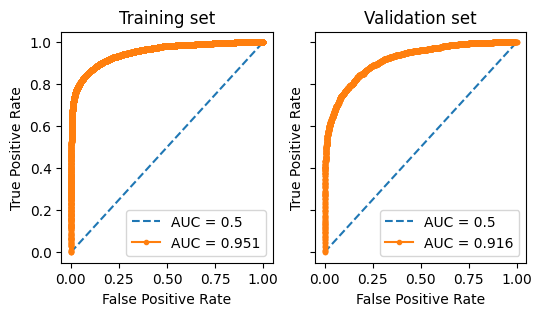

In [64]:
# compute auc scores
ns_prob = [0 for _ in range(len(y_train))]
ns_auc = roc_auc_score(y_train, ns_prob)
xgb_auc_train = roc_auc_score(y_train, prob_train)
xgb_auc_val = roc_auc_score(y_val, prob_val)

# plot the roc curve 
ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_prob)
train_fpr, train_tpr, _ = roc_curve(y_train, prob_train)
val_fpr, val_tpr, _ = roc_curve(y_val, prob_val)

fig, ax = plt.subplots(1, 2, figsize=(6,3), sharey=True)

title_list = ['Training set', 'Validation set']
for col, fpr, tpr, auc_score in zip([0, 1], [train_fpr, val_fpr], [train_tpr, val_tpr], [xgb_auc_train, xgb_auc_val]):
    ax[col].plot(ns_fpr, ns_tpr, linestyle='--', label='AUC = 0.5')
    ax[col].plot(fpr, tpr, marker='.', label='AUC = %.3f' % (auc_score))
    ax[col].set_title(title_list[col])
    ax[col].set_xlabel('False Positive Rate')
    ax[col].set_ylabel('True Positive Rate')
    ax[col].legend()

plt.show()

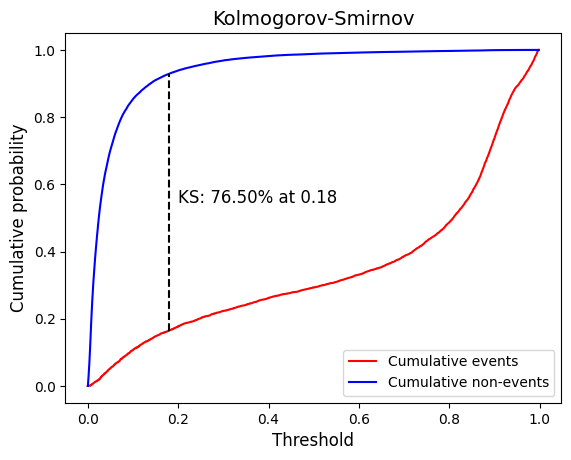

In [78]:
# Find the score threshold based on KS Plot
scorecard.plot_ks(y_train, prob_train)

In [85]:
threshold = 0.18

pred_train = pd.DataFrame(prob_train, index=y_train.index)
pred_train.columns = ['probability']
pred_train['true'] = y_train
pred_train['prediction'] = np.where(pred_train['probability'] > threshold, 1, 0)

pred_val = pd.DataFrame(prob_val, index=y_val.index)
pred_val.columns = ['probability']
pred_val['true'] = y_val
pred_val['prediction'] = np.where(pred_val['probability'] > threshold, 1, 0)

pred_test = pd.DataFrame(prob_test)
pred_test.columns = ['probability']
pred_test['prediction'] = np.where(pred_test['probability'] > threshold, 1, 0)

In [87]:
# Model Evaluation
print('==== Training set')
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_train, pred_train['prediction'])))
print(classification_report(y_train, pred_train['prediction']))

==== Training set
Confusion Matrix
       0     1
0  37375  2859
1   1097  5582
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     40234
           1       0.66      0.84      0.74      6679

    accuracy                           0.92     46913
   macro avg       0.82      0.88      0.84     46913
weighted avg       0.93      0.92      0.92     46913



In [86]:
# Model Evaluation
print('==== Testing set')
print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_val, pred_val['prediction'])))
print(classification_report(y_val, pred_val['prediction']))

==== Testing set
Confusion Matrix
      0     1
0  7984  2075
1   243  1427
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     10059
           1       0.41      0.85      0.55      1670

    accuracy                           0.80     11729
   macro avg       0.69      0.82      0.71     11729
weighted avg       0.89      0.80      0.83     11729



## Feature importances 

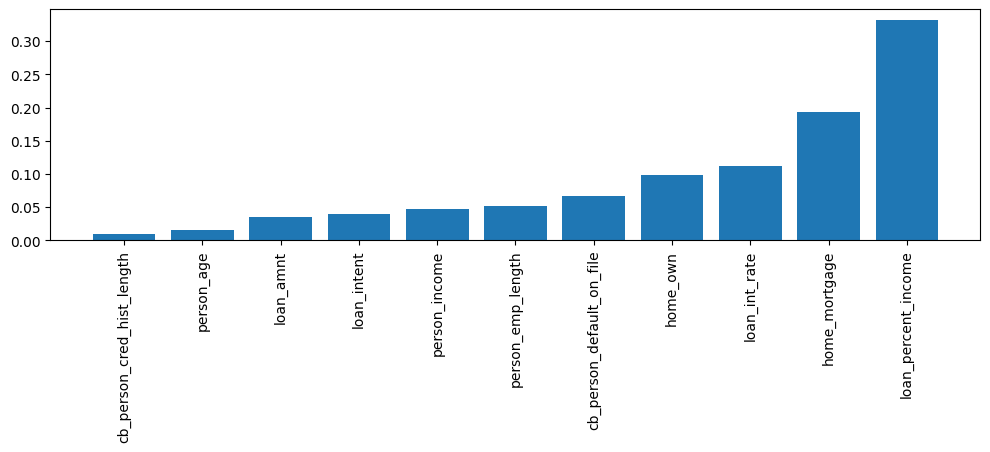

In [65]:
# Feature importances
FeatureXgb = pd.DataFrame({'feature':X_train.columns, 'importance':list(xgb_hyp.feature_importances_)}).sort_values('importance')
plt.figure(figsize=(12,3))
plt.bar(x=FeatureXgb['feature'], height=FeatureXgb['importance'])
plt.xticks(rotation=90)
plt.show()

In [91]:
# Save
pickle.dump(xgb_hyp, open('xgb_risk.pkl', 'wb'))

pred_train.index = y_train.index
pred_train.to_csv('pred_train.csv')

pred_val.index = y_val.index
pred_val.to_csv('pred_val.csv')

pred_test.index = test.index
pred_test.to_csv('pred_test.csv')

# Submission

In [102]:
submission = pred_test.drop(columns=['prediction'])
submission = submission.reset_index()
submission.columns = ['id', 'loan_status']
submission.head()

,id,loan_status
0,58645,0.960826
1,58646,0.070265
2,58647,0.833249
3,58648,0.033557
4,58649,0.122010


In [104]:
submission.to_csv('submission.csv')